In [45]:
import os
import sys
import pickle

sys.path.append( '../model_code/')
sys.path.append( '../data_processing_code/')

import models_ym1 as model_specific
import get_data
from get_data import get_data
import model_base
from model_base import * 

import matplotlib.pyplot as plt 

In [2]:
with open(f'{os.getcwd()}/model_fits/model=ym1_covariate=Bi3itemCDM_date=2021_9_7_samples=2000_seed=3_exp=1.pkl', 'rb') as handle:
    ym1_res =   pickle.load(handle)


In [3]:
Theta_est = ym1_res['trace']['Theta'].mean(axis=0)

In [21]:
params = ym1_res['model'].params

In [23]:
params, len(params)

(['lr_baseline',
  'lr_goodbad',
  'lr_stabvol',
  'lr_goodbad_stabvol',
  'lr_c_baseline',
  'lr_c_goodbad',
  'lr_c_stabvol',
  'lr_c_goodbad_stabvol',
  'Binv_baseline',
  'Binv_goodbad',
  'Binv_stabvol',
  'Binv_goodbad_stabvol',
  'Bc_baseline',
  'mag_baseline',
  'lr_rewpain',
  'lr_rewpain_goodbad',
  'lr_rewpain_stabvol',
  'lr_rewpain_goodbad_stabvol',
  'lr_c_rewpain',
  'lr_c_rewpain_goodbad',
  'lr_c_rewpain_stabvol',
  'lr_c_rewpain_goodbad_stabvol',
  'Binv_rewpain',
  'Binv_rewpain_goodbad',
  'Binv_rewpain_stabvol',
  'Bc_rewpain',
  'mag_rewpain'],
 27)

In [5]:
# input experiment condition
data = get_data(pd.read_csv( '../data/participant_table_exp1.csv'))
X = {}
X['NN'] = data['outcomes_c_flipped'].shape[1]
X['Nboth'] = data[ 'Nboth']
X['Nrewonly'] = data[ 'Nrewonly']
X['Npainonly'] = data[ 'Npainonly']
subj_ind_both = slice( 0, X['Nboth'])
subj_ind_rewonly = slice( 0, X['Nrewonly'])
subj_ind_painonly = slice( 0, X['Npainonly'])

for var in ['outcomes_c_flipped','mag_1_c','mag_0_c','stabvol','rewpain']:
    X[var]=data[var]

pain task excluded:12
rew task excluded:9
has both: 71
pain only:6
rew only:9
subj X task:157
subjs:86
(180, 157)
(180, 157)
(180, 157)
(180, 157)


In [6]:
# prepare the prediction
Y = {}
Y['participants_choice'] = data['participants_choice']

In [8]:
f, roi_vars = model_specific.create_gen_choice_model( X, Y, param_names=params)

/opt/anaconda3/envs/pymc3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


In [11]:
sim_data = f(Theta_est)

In [18]:
history = dict()
history['ps1']    = sim_data[ 4]
history['qc1']    = sim_data[ 5]
history['pi1_s1'] = sim_data[-2]
history['pi1_s2'] = sim_data[-1]
history['mag_1']  = X['mag_1_c']
history['mag_2']  = X['mag_0_c']

In [34]:
def cal_mi_reward( in_data):
    
    # unpack the data
    ps1, qc1, pi1_s1, pi1_s2, mag_1, mag_2 = in_data
    
    # define a small number to avoid the log issue
    eps = 1e-10
    
    # rewrite ps, qc, pi, Q in the form of matrix 
    # follow the shape of |S| x |C|
    ps = np.array( [ ps1, 1-ps1]).reshape([ -1,  1])
    qc = np.array( [ qc1, 1-qc1]).reshape([  1, -1])
    pi = np.array( [[ pi1_s1, 1-pi1_s1], 
                    [ pi1_s2, 1-pi1_s2]])
    Q  = np.array( [[ mag_1,     0], 
                    [     0, mag_2]])
    
    E_utility = np.sum( ps * pi * ( np.log( pi + eps) - np.log( qc + eps)))  
    pi_comp   = np.sum( ps * pi * Q)
    psi_comp  = -np.sum( ps * np.log( ps + eps))
    
    return E_utility, psi_comp, pi_comp

In [42]:
roi_vars     = [ 'ps1', 'qc1', 'pi1_s1', 'pi1_s2', 'mag_1', 'mag_2']
roi_features = [ 'E_U', 'pi_comp', 'psi_comp']

for phi in roi_features:
    T, N = history['ps1'].shape
    history[phi] = np.zeros( [ T, N]) + np.nan
    
for t in range(T):
    for n in range(N):
        in_data = [ history[var][t, n] for var in roi_vars]
        E_U, psi_comp, pi_comp    = cal_mi_reward( in_data)
        history['E_U'][t, n]      = E_U
        history['psi_comp'][t, n] = psi_comp
        history['pi_comp'][t, n]  = pi_comp
        
    

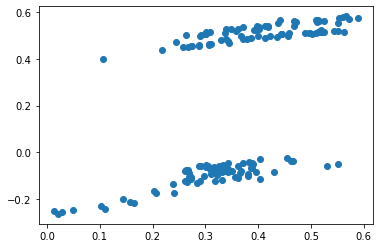

In [49]:
plt.scatter( np.mean(history['E_U'],0), np.mean(history['pi_comp'],0))